In [94]:
%load_ext autoreload
%autoreload 2
import sys 
if '/Users/ericliu/Desktop/Latent-Dirichilet-Allocation' not in sys.path: 
    sys.path.append('/Users/ericliu/Desktop/Latent-Dirichilet-Allocation')
import torch as tr 
import numpy as np 
import pandas as pd 
from collections import defaultdict
from pprint import pprint
import matplotlib.pyplot as plt 

from sklearn.decomposition import LatentDirichletAllocation 
from src.lda_model import LDASmoothed 
from src.generator import doc_generator 
from src.utils import (
    get_vocab_from_docs, 
    get_np_wct, 
    data_loader,
    text_pipeline, 
    process_documents,
    compute_elbo,
) 
from src.text_pre_processor import (
    remove_accented_chars, 
    remove_special_characters, 
    remove_punctuation,
    remove_extra_whitespace_tabs,
    remove_stopwords,
)
from pprint import pprint 
import copy  

from src.cutils import (
    _dirichlet_expectation_1d, 
    _dirichlet_expectation_2d,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Document Generation

In [2]:
gen = doc_generator(
    M = 5,
    L = 20, 
    topic_prior = tr.tensor([1,1,1,1,1], dtype=tr.double)
)

In [3]:
gen.beta

tensor([[0.1131, 0.0589, 0.0824, 0.1060, 0.0471, 0.0824, 0.0294, 0.1060, 0.0059,
         0.0047, 0.0353, 0.0059, 0.0118, 0.0035, 0.0012, 0.0012, 0.0118, 0.0118,
         0.0236, 0.0236, 0.0177, 0.0177, 0.0041, 0.0047, 0.0353, 0.0059, 0.0118,
         0.0353, 0.0177, 0.0118, 0.0029, 0.0035, 0.0029, 0.0012, 0.0353, 0.0029,
         0.0059, 0.0118, 0.0029, 0.0029],
        [0.0012, 0.0047, 0.0047, 0.0030, 0.0355, 0.0118, 0.0237, 0.0030, 0.0948,
         0.0592, 0.0592, 0.1066, 0.0474, 0.1066, 0.0948, 0.1126, 0.0237, 0.0059,
         0.0059, 0.0118, 0.0178, 0.0178, 0.0041, 0.0047, 0.0047, 0.0237, 0.0118,
         0.0296, 0.0059, 0.0237, 0.0030, 0.0036, 0.0030, 0.0012, 0.0036, 0.0030,
         0.0047, 0.0118, 0.0030, 0.0030],
        [0.0014, 0.0057, 0.0043, 0.0036, 0.0143, 0.0071, 0.0286, 0.0036, 0.0071,
         0.0043, 0.0214, 0.0014, 0.0428, 0.0043, 0.0143, 0.0014, 0.0500, 0.0999,
         0.0999, 0.0571, 0.0857, 0.0857, 0.1285, 0.1285, 0.0057, 0.0014, 0.0143,
         0.0071, 0.0071, 

In [4]:
gen.alpha

Dirichlet(concentration: torch.Size([5]))

In [5]:
gen.theta.shape

torch.Size([5, 5])

In [6]:
gen.theta

tensor([[0.1576, 0.2149, 0.2098, 0.3748, 0.0428],
        [0.5228, 0.0468, 0.0134, 0.2321, 0.1848],
        [0.0158, 0.2380, 0.0015, 0.4310, 0.3136],
        [0.5161, 0.1350, 0.2331, 0.0053, 0.1105],
        [0.3208, 0.3488, 0.0661, 0.2121, 0.0522]], dtype=torch.float64)

In [7]:
docs = gen.generate_doc()

Document: 0 | word: 0 -> topic: sport -> word: recreation
Document: 0 | word: 1 -> topic: health -> word: bruise
Document: 0 | word: 2 -> topic: health -> word: injection
Document: 0 | word: 3 -> topic: science -> word: quantum
Document: 0 | word: 4 -> topic: sport -> word: decongestant
Document: 0 | word: 5 -> topic: health -> word: injection
Document: 0 | word: 6 -> topic: art -> word: genetics
Document: 0 | word: 7 -> topic: art -> word: game
Document: 0 | word: 8 -> topic: health -> word: decongestant
Document: 0 | word: 9 -> topic: art -> word: picture
Document 0: recreation bruise injection quantum decongestant injection genetics game decongestant picture

Document: 1 | word: 0 -> topic: health -> word: injection
Document: 1 | word: 1 -> topic: science -> word: research
Document: 1 | word: 2 -> topic: sport -> word: athletics
Document: 1 | word: 3 -> topic: health -> word: decongestant
Document: 1 | word: 4 -> topic: health -> word: fever
Document: 1 | word: 5 -> topic: sport -> 

In [8]:
docs

{0: 'recreation bruise injection quantum decongestant injection genetics game decongestant picture',
 1: 'injection research athletics decongestant fever FIFA energy Technique electricity astrophysics',
 2: 'Technique fever exercise contract Olympic contract bankrupt research bruise Technique',
 3: 'research copyright Symmetrical Craftsmanship athletics game fever electricity quantum asymmetrical',
 4: 'scientst picture form quantum recreation bruise exercise research picture scientst'}

In [9]:
#docs_raw_dict, raw_word_2_idx, raw_idx_2_word = data_loader('ap')

In [10]:
result = process_documents(docs, sample=True)

There are 5 documents in the dataset after processing
On average estimated document length is 10.0 words per document after processing
There are 26 unique vocab in the corpus after processing


In [11]:
print(result.keys())

dict_keys(['documents', 'vocab_doc_count_dict', 'vocab_doc_count_array', 'vocab_to_idx', 'idx_to_vocab'])


In [49]:
doc_vocab_count = np.zeros(
    (
        len(docs), len(result['vocab_to_idx'])
    ),
    dtype = float,
)

for doc_idx, doc in enumerate(result['documents']): 
    for word in doc: 
        vocab_idx = result['vocab_to_idx'][word]
        doc_vocab_count[doc_idx, vocab_idx] += 1 

doc_vocab_count

array([[1., 1., 2., 1., 2., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 0., 0.,
        1., 2., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 0., 0.],
       [1., 1., 0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 2., 1.]])

In [50]:
doc_vocab_count_df = pd.DataFrame(
    data = doc_vocab_count,
    columns = list(result['vocab_to_idx'].keys())
)
doc_vocab_count_df

,recreation,bruise,injection,quantum,decongestant,genetics,game,picture,research,athletics,...,exercise,contract,Olympic,bankrupt,copyright,Symmetrical,Craftsmanship,asymmetrical,scientst,form
0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
4,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0


# Our Model

In [157]:
lda = LDASmoothed(
    docs = result['documents'],
    num_topics = 5, 
    word_ct_dict = result['vocab_doc_count_dict'], 
    num_doc_population = 100,
    word_ct_array = result['vocab_doc_count_array'],
)
print(f'Size of the vocab is {lda.V}')

Topic Dirichlet Prior, Alpha
1

Exchangeable Word Dirichlet Prior, Eta 
1

Var Inf - Word Dirichlet prior, Lambda
(5, 26)

Var Inf - Topic Dirichlet prior, Gamma
(5, 5)

Size of the vocab is 26


In [158]:
%%time
perplexity, expec_logs = \
    lda.approx_perplexity(
    doc_vocab_count,
    sampling=False,
)

print(perplexity)

62.12126028548294
CPU times: user 1.06 ms, sys: 530 µs, total: 1.59 ms
Wall time: 1.36 ms


In [159]:
expec_log_theta, expect_log_beta = expec_logs[0], expec_logs[1]

- check hyperparameters 

In [160]:
print(lda._alpha_)
print(lda._eta_)

1
1


- check var inf parameteres 

In [161]:
print('lambda')
print(lda._lambda_.shape)
print(lda._lambda_)

lambda
(5, 26)
[[1.04708219 0.98292693 0.97347267 0.97347428 1.16278368 1.07526208
  0.95052839 1.05181933 1.02101821 0.81760009 0.89893338 1.0283693
  1.15026429 0.97429619 0.94330106 1.00778149 0.9378975  0.96782864
  0.9953198  0.89475728 1.08105987 0.87968664 0.86986295 1.01644942
  1.07222286 1.01387299]
 [0.98516565 0.96690772 0.95138329 1.10597141 1.02937237 0.95871485
  0.93060329 1.05898791 1.1031785  1.09256024 0.91521059 0.96611462
  0.94959045 0.9782464  1.08000428 1.13828828 1.03320764 0.93363961
  0.99309432 1.16117251 1.00538214 0.96711283 0.97489658 1.03274514
  0.91811143 0.94740917]
 [1.09087585 1.02984852 1.00638968 1.09653088 0.92820856 0.96431168
  1.02652255 1.02295647 0.86193808 0.95525935 0.98065155 1.03755099
  1.02260049 0.98925295 0.81711981 0.99402204 1.00269174 1.26335968
  0.97758574 1.02707522 1.11516717 1.07363499 1.14337395 0.86316381
  0.90101275 0.9411936 ]
 [0.84973584 1.00352721 0.90766658 1.15954736 0.92049911 0.96485874
  1.0801087  0.87876646 0.8

In [162]:
print('gamma')
print(lda._gamma_)

gamma
[[6.2 6.2 6.2 6.2 6.2]
 [6.2 6.2 6.2 6.2 6.2]
 [6.2 6.2 6.2 6.2 6.2]
 [6.2 6.2 6.2 6.2 6.2]
 [6.2 6.2 6.2 6.2 6.2]]


In [163]:
perplexity, expec_logs = \
    lda.approx_perplexity(
    doc_vocab_count,
    sampling=False,
)
print(perplexity)

62.12126028548294


In [164]:
%%time
gamma, lambda_update = \
    lda.e_step_batch(
    X = doc_vocab_count,
    expec_log_theta= expec_log_theta,
    expec_log_beta= expect_log_beta,
    verbose = True,
)

Before Estep perplexity = 62.12126028548294
After Estep perplexity = 59.264073758700476
CPU times: user 2.27 ms, sys: 660 µs, total: 2.93 ms
Wall time: 2.49 ms


In [165]:
gamma

array([[3.13562501, 2.96984033, 3.02337614, 2.86631146, 3.00484706],
       [3.0545475 , 3.10617699, 2.90002681, 2.98764043, 2.95160828],
       [2.92219523, 3.02217066, 3.14452562, 3.05106973, 2.86003877],
       [2.83538701, 3.05355781, 2.95403925, 3.05000578, 3.10701015],
       [3.08156684, 3.00389023, 2.92956492, 2.82472603, 3.16025198]])

In [166]:
lambda_update

(array([[0.44140348, 0.58750864, 0.61365755, 0.50046016, 0.74600161,
         0.23697112, 0.38666002, 0.64657929, 0.89341128, 0.29043021,
         0.53130048, 0.20514124, 0.24553752, 0.61703839, 0.39416546,
         0.20221874, 0.37448152, 0.37021784, 0.19038513, 0.16670337,
         0.21440952, 0.15744955, 0.15285668, 0.20777038, 0.4661783 ,
         0.19038409],
        [0.39351832, 0.56299336, 0.58156625, 0.60591669, 0.6059546 ,
         0.19348588, 0.36738185, 0.64376135, 0.99598297, 0.46723468,
         0.53968564, 0.18227962, 0.17747203, 0.61179076, 0.48456947,
         0.24186177, 0.43297253, 0.34317184, 0.18680876, 0.25128788,
         0.1878155 , 0.18233315, 0.18296804, 0.20998494, 0.35530497,
         0.16753318],
        [0.4649116 , 0.62569323, 0.63962022, 0.59883027, 0.5110805 ,
         0.19572335, 0.43323412, 0.60981488, 0.66127426, 0.37605232,
         0.60745615, 0.20532192, 0.20098961, 0.62433083, 0.30233033,
         0.19504282, 0.4130221 , 0.55579901, 0.1823196 , 0.

In [167]:
perplexities = lda.em_step_batch(
    doc_vocab_count,
    sampling= True,
    threshold= 1e-07,
    )
print(len(perplexities))

101


In [168]:
perplexities[-1]

45.833673713056136

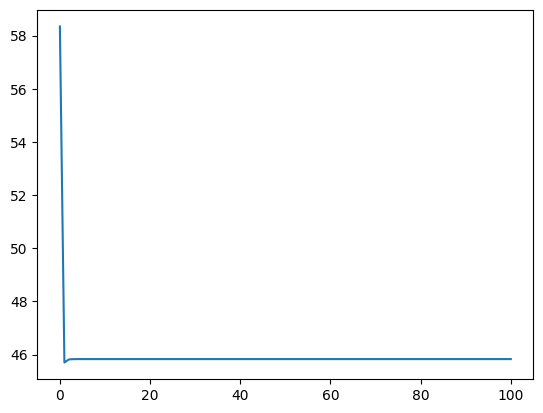

In [169]:
plt.plot(
    perplexities)

# Target model

In [80]:
sklearn_lda = LatentDirichletAllocation(
    n_components=5,
    random_state=42,
    doc_topic_prior= 1,
    topic_word_prior= 1,
)
sklearn_lda._init_latent_vars(n_features = lda.V)

- check hyperparameters

In [81]:
# alpha 
print(f"alpha -> {sklearn_lda.doc_topic_prior}")
print(f"eta -> {sklearn_lda.topic_word_prior}")

alpha -> 1
eta -> 1


- var inf parameters 

In [82]:
print('lambda')
print(sklearn_lda.components_)

lambda
[[1.04708219 0.98292693 0.97347267 0.97347428 1.16278368 1.07526208
  0.95052839 1.05181933 1.02101821 0.81760009 0.89893338 1.0283693
  1.15026429 0.97429619 0.94330106 1.00778149 0.9378975  0.96782864
  0.9953198  0.89475728 1.08105987 0.87968664 0.86986295 1.01644942
  1.07222286 1.01387299]
 [0.98516565 0.96690772 0.95138329 1.10597141 1.02937237 0.95871485
  0.93060329 1.05898791 1.1031785  1.09256024 0.91521059 0.96611462
  0.94959045 0.9782464  1.08000428 1.13828828 1.03320764 0.93363961
  0.99309432 1.16117251 1.00538214 0.96711283 0.97489658 1.03274514
  0.91811143 0.94740917]
 [1.09087585 1.02984852 1.00638968 1.09653088 0.92820856 0.96431168
  1.02652255 1.02295647 0.86193808 0.95525935 0.98065155 1.03755099
  1.02260049 0.98925295 0.81711981 0.99402204 1.00269174 1.26335968
  0.97758574 1.02707522 1.11516717 1.07363499 1.14337395 0.86316381
  0.90101275 0.9411936 ]
 [0.84973584 1.00352721 0.90766658 1.15954736 0.92049911 0.96485874
  1.0801087  0.87876646 0.84464572 

In [83]:
assert (sklearn_lda.components_ == lda._lambda_).all()

In [84]:
%%time
sklearn_lda._approx_bound(
    doc_vocab_count,
    doc_topic_distr = lda._gamma_,
    sub_sampling = False,
)

CPU times: user 319 µs, sys: 35 µs, total: 354 µs
Wall time: 324 µs


-204.1001641800722

In [85]:
sklearn_lda._perplexity_precomp_distr(
    doc_vocab_count, 
    doc_topic_distr = lda._gamma_,
    sub_sampling=False)

59.264073758700476

In [86]:
gamma_ref, lambda_update_ref = \
    sklearn_lda._e_step(
    doc_vocab_count,
    cal_sstats = True, 
    random_init = 42,
)

In [89]:
sklearn_lda._perplexity_precomp_distr(
    doc_vocab_count, 
    doc_topic_distr = gamma_ref,
    sub_sampling=False)

59.11753479956428

In [90]:
gamma_ref

array([[3.72111531, 2.80781167, 3.04680646, 2.46274457, 2.96152199],
       [3.22198091, 3.54009169, 2.57684175, 2.90511567, 2.75596999],
       [2.62303183, 3.02777697, 3.74765055, 3.17070831, 2.43083234],
       [2.37305677, 3.19697302, 2.7470429 , 3.17161434, 3.51131297],
       [3.29471414, 2.92008134, 2.63492273, 2.32817005, 3.82211174]])

In [77]:
lambda_update_ref

array([[0.52374703, 0.63706979, 0.74544375, 0.52901593, 0.89436034,
        0.30064181, 0.39629033, 0.74927396, 0.84574846, 0.26469737,
        0.47728495, 0.22418988, 0.26677692, 0.56889917, 0.35787873,
        0.21713354, 0.37059184, 0.30740746, 0.16155715, 0.13931054,
        0.16233942, 0.11688584, 0.11399609, 0.15527439, 0.51412976,
        0.20275485],
       [0.36760558, 0.54475425, 0.59184179, 0.600847  , 0.60861486,
        0.17670466, 0.37004858, 0.60530263, 1.05779857, 0.52893926,
        0.59436666, 0.22176438, 0.21465991, 0.65444556, 0.54730565,
        0.28911017, 0.42967338, 0.33925961, 0.18873561, 0.2500199 ,
        0.20370989, 0.19390405, 0.19547064, 0.22480456, 0.33854884,
        0.15414904],
       [0.43028668, 0.66089421, 0.61064046, 0.5553784 , 0.48154372,
        0.19732036, 0.41840895, 0.54751445, 0.64057388, 0.32176483,
        0.61302691, 0.17176881, 0.16716677, 0.70568295, 0.25839489,
        0.16031768, 0.44404069, 0.70303299, 0.23568251, 0.26390918,
      

In [91]:
lambda_update - lambda_update_ref

array([[-0.0817802 , -0.04915322, -0.13206138, -0.02812074, -0.14861077,
        -0.06395462, -0.0099369 , -0.10129618,  0.04856781,  0.02589214,
         0.05408611, -0.0188146 , -0.02097825,  0.04812375,  0.03649137,
        -0.01467307,  0.00451795,  0.06257711,  0.02872149,  0.02727561,
         0.05203752,  0.04053141,  0.03882948,  0.0524456 , -0.04619352,
        -0.01159687],
       [ 0.02582644,  0.01851811, -0.01049939,  0.00509795, -0.00284629,
         0.0168062 , -0.00259552,  0.0382842 , -0.061729  , -0.06189618,
        -0.05452058, -0.03973607, -0.03744513, -0.04219924, -0.06294086,
        -0.04755595,  0.00358125,  0.00450985, -0.00157563,  0.00168778,
        -0.01580658, -0.01150197, -0.01243244, -0.01475053,  0.01656732,
         0.01335972],
       [ 0.03485325, -0.03493382,  0.02982779,  0.04353213,  0.03024793,
        -0.00124667,  0.01501464,  0.06237905,  0.02052637,  0.05424158,
        -0.00559581,  0.03364301,  0.03389945, -0.0811874 ,  0.0438913 ,
       